In [34]:
import pprint
import random
import torch
import pandas as pd
import numpy as np
import transformers
from sklearn.metrics import recall_score, precision_score, f1_score, matthews_corrcoef
from transformers import BertTokenizer, BertForSequenceClassification

from utils import preprocess_text, labelnum

In [35]:
seed = 42
SENTIMENT_MODEL_PATH = './models/sentiment/'

In [36]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
transformers.set_seed(seed)

# seBERT

In [37]:
model = BertForSequenceClassification.from_pretrained(SENTIMENT_MODEL_PATH)
tokenizer = BertTokenizer.from_pretrained(SENTIMENT_MODEL_PATH)

In [38]:
df = pd.read_csv('./data/processed/evaluation.csv')
df['text'] = df['text'].apply(preprocess_text)
df['label'] = df['label'].map(labelnum)

df['label'].value_counts()

label
1    933
0    499
2    375
Name: count, dtype: int64

In [39]:
X = [str(i) for i in df['text'].tolist()]
y_test = [int(i) for i in df['label'].tolist()]

data_len = len(df)
y_probs = []

model.eval()
with torch.no_grad():
    for _, X_row in enumerate(X):
        inputs = tokenizer(X_row, padding=True, truncation=True, max_length=128, return_tensors='pt').to('cuda')
        outputs = model.to('cuda')(**inputs)
        probs = outputs[0].softmax(1).cpu().detach().numpy()
        y_probs.append(probs)
            
y_pred = []
for y_prob in y_probs:
    y_pred.append(y_prob.argmax())

In [40]:
def get_metrics(y_test, y_pred, identifier):
    return [{'model': identifier,
            'mcc': matthews_corrcoef(y_true=y_test, y_pred=y_pred),
            'micro_f1': f1_score(y_true=y_test, y_pred=y_pred, average='micro'),
            'micro_precision': precision_score(y_true=y_test, y_pred=y_pred, average='micro'),
            'micro_recall': recall_score(y_true=y_test, y_pred=y_pred, average='micro'),
            'macro_f1': f1_score(y_true=y_test, y_pred=y_pred, average='macro'),
            'macro_precision': precision_score(y_true=y_test, y_pred=y_pred, average='macro'),
            'macro_recall': recall_score(y_true=y_test, y_pred=y_pred, average='macro'),
            'precision_negative': precision_score(y_true=y_test, y_pred=y_pred, average=None, labels=[0])[0],
            'precision_neutral': precision_score(y_true=y_test, y_pred=y_pred, average=None, labels=[1])[0],
            'precision_positive': precision_score(y_true=y_test, y_pred=y_pred, average=None, labels=[2])[0],
            'recall_negative': recall_score(y_true=y_test, y_pred=y_pred, average=None, labels=[0])[0],
            'recall_neutral': recall_score(y_true=y_test, y_pred=y_pred, average=None, labels=[1])[0],
            'recall_positive': recall_score(y_true=y_test, y_pred=y_pred, average=None, labels=[2])[0],
            'f1_negative': f1_score(y_true=y_test, y_pred=y_pred, average=None, labels=[0])[0],
            'f1_neutral': f1_score(y_true=y_test, y_pred=y_pred, average=None, labels=[1])[0],
            'f1_positive': f1_score(y_true=y_test, y_pred=y_pred, average=None, labels=[2])[0]}]

In [41]:
results = get_metrics(y_test, y_pred, 'seBERT')

pprint.pprint(results)

result_df = pd.DataFrame(results)
result_df.to_csv('./models/evaluation/evaluated.csv', index=False)

[{'f1_negative': 0.8679631525076765,
  'f1_neutral': 0.898828541001065,
  'f1_positive': 0.8089591567852438,
  'macro_f1': 0.8585836167646618,
  'macro_precision': 0.8598767161637628,
  'macro_recall': 0.8576582847724746,
  'mcc': 0.7906306558793941,
  'micro_f1': 0.8716104039845047,
  'micro_precision': 0.8716104039845047,
  'micro_recall': 0.8716104039845047,
  'model': 'seBERT',
  'precision_negative': 0.8870292887029289,
  'precision_neutral': 0.8931216931216931,
  'precision_positive': 0.7994791666666666,
  'recall_negative': 0.8496993987975952,
  'recall_neutral': 0.9046087888531619,
  'recall_positive': 0.8186666666666667}]


# SentiStrength-SE_v1.5

In [42]:
ssse = pd.read_csv('./data/processed/evaluation_ssse_preds.csv')
ssse['text'] = ssse['text'].apply(preprocess_text)
ssse['label'] = ssse['label'].map(labelnum)

ssse_preds = [int(i) for i in ssse['label'].tolist()]

In [43]:
ssse_results = get_metrics(y_test, ssse_preds, 'SentiStrength-SE_v1.5')

pprint.pprint(ssse_results)

ssse_results_df = pd.DataFrame(ssse_results)
ssse_results_df.to_csv('./models/evaluation/evaluated.csv', index=False, mode='a', header=False)

[{'f1_negative': 0.5935162094763092,
  'f1_neutral': 0.7846580406654344,
  'f1_positive': 0.6172839506172839,
  'macro_f1': 0.6651527335863426,
  'macro_precision': 0.7359208216194809,
  'macro_recall': 0.6400850289360429,
  'mcc': 0.518269787755953,
  'micro_f1': 0.7122302158273381,
  'micro_precision': 0.7122302158273381,
  'micro_recall': 0.7122302158273381,
  'model': 'SentiStrength-SE_v1.5',
  'precision_negative': 0.7854785478547854,
  'precision_neutral': 0.6896831844029244,
  'precision_positive': 0.7326007326007326,
  'recall_negative': 0.47695390781563124,
  'recall_neutral': 0.909967845659164,
  'recall_positive': 0.5333333333333333}]


# Plot

In [47]:
import matplotlib.pyplot as plt

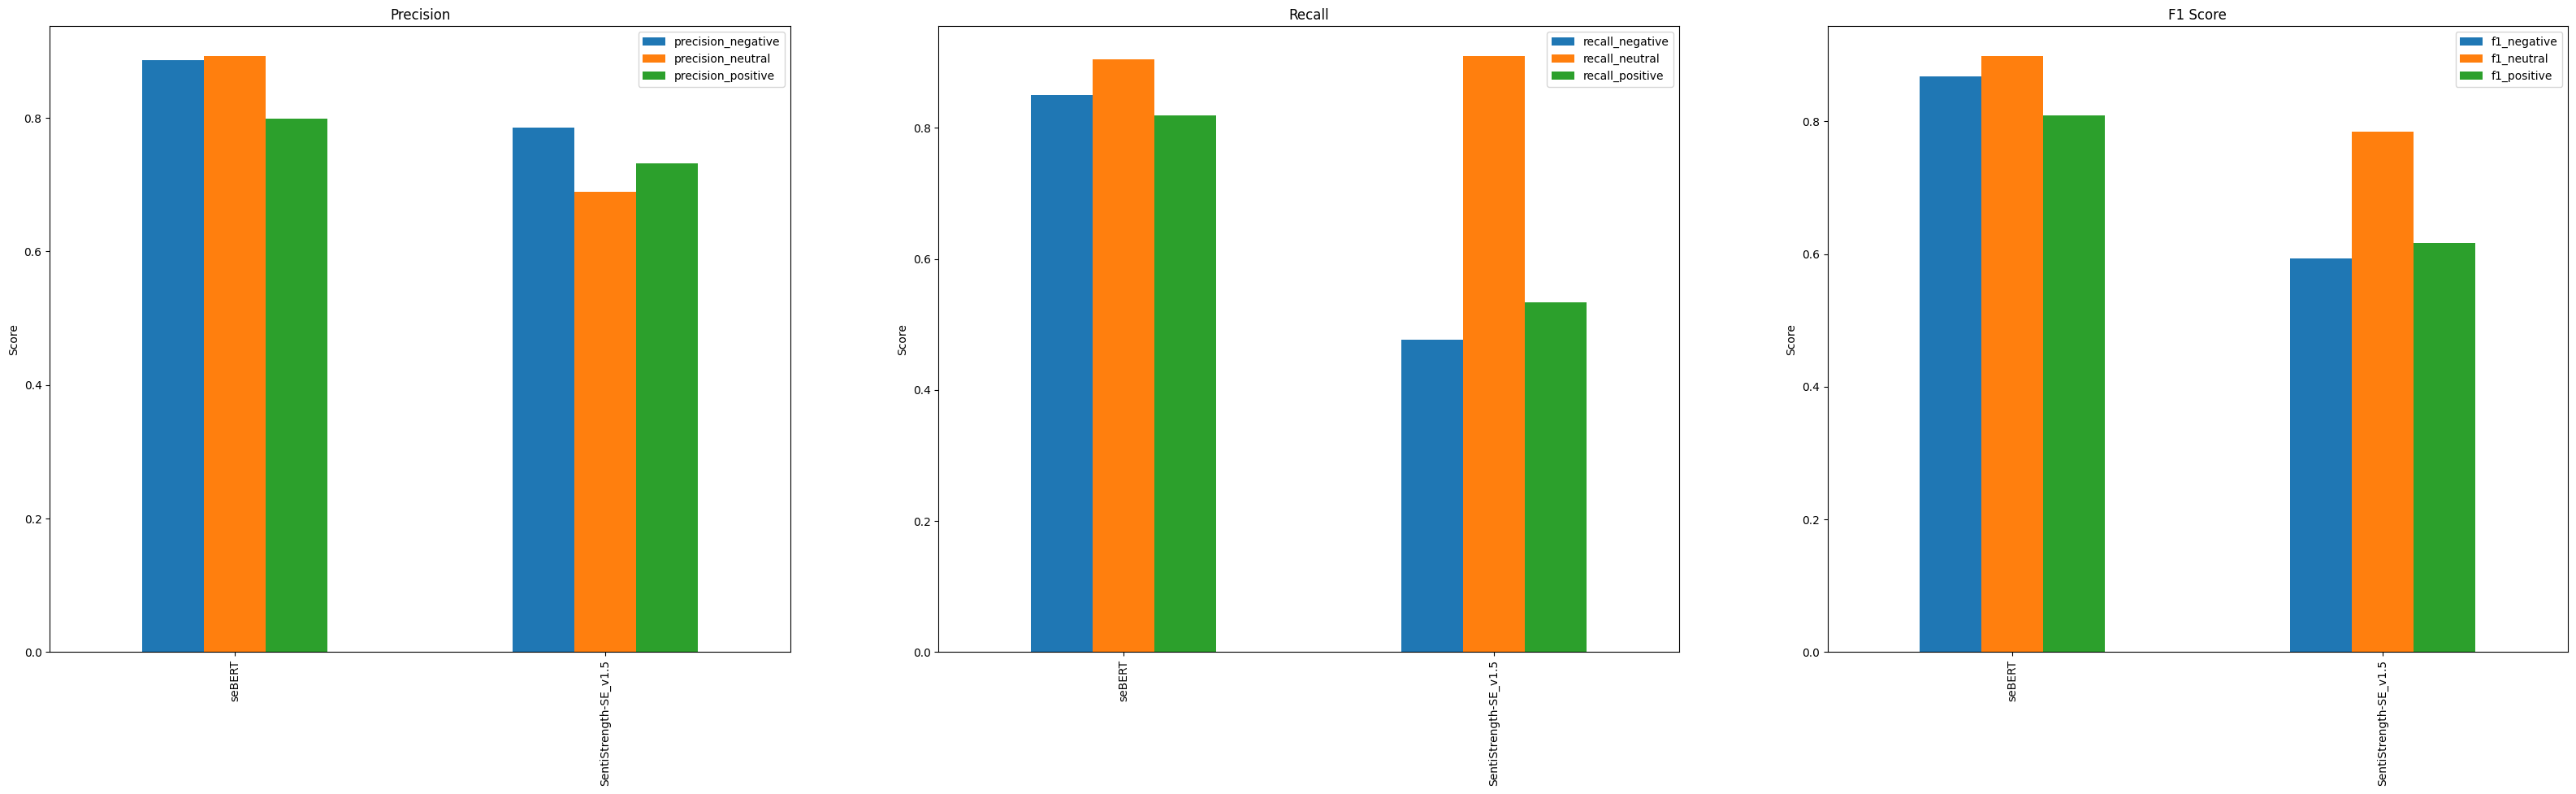

In [50]:
evaluated = pd.read_csv('./models/evaluation/evaluated.csv')

# plot precision, recall, f1 score for each class for both of the models
fig, ax = plt.subplots(1, 3, figsize=(40, 10))

evaluated[['precision_negative', 'precision_neutral', 'precision_positive']].plot(kind='bar', ax=ax[0])
ax[0].set_title('Precision')
ax[0].set_xticklabels(['seBERT', 'SentiStrength-SE_v1.5'])
ax[0].set_ylabel('Score')

evaluated[['recall_negative', 'recall_neutral', 'recall_positive']].plot(kind='bar', ax=ax[1])
ax[1].set_title('Recall')
ax[1].set_xticklabels(['seBERT', 'SentiStrength-SE_v1.5'])
ax[1].set_ylabel('Score')

evaluated[['f1_negative', 'f1_neutral', 'f1_positive']].plot(kind='bar', ax=ax[2])
ax[2].set_title('F1 Score')
ax[2].set_xticklabels(['seBERT', 'SentiStrength-SE_v1.5'])
ax[2].set_ylabel('Score')

plt.show()